In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate
parent_dir = os.path.join(os.getcwd(), '..', '..')
if parent_dir not in sys.path: sys.path.append(parent_dir)
from utility.data import get_loader, EmbeddingDataset
from model.gan import Generator, Discriminator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from datasets import load_from_disk
from model.dnn import DNNClassifier
from sklearn.metrics import accuracy_score
from utility.visuals import *

C:\Users\ss348\AppData\Local\Temp\ipykernel_54368\1448506067.py:95: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Table has been saved as 'accuracy_summary.png'


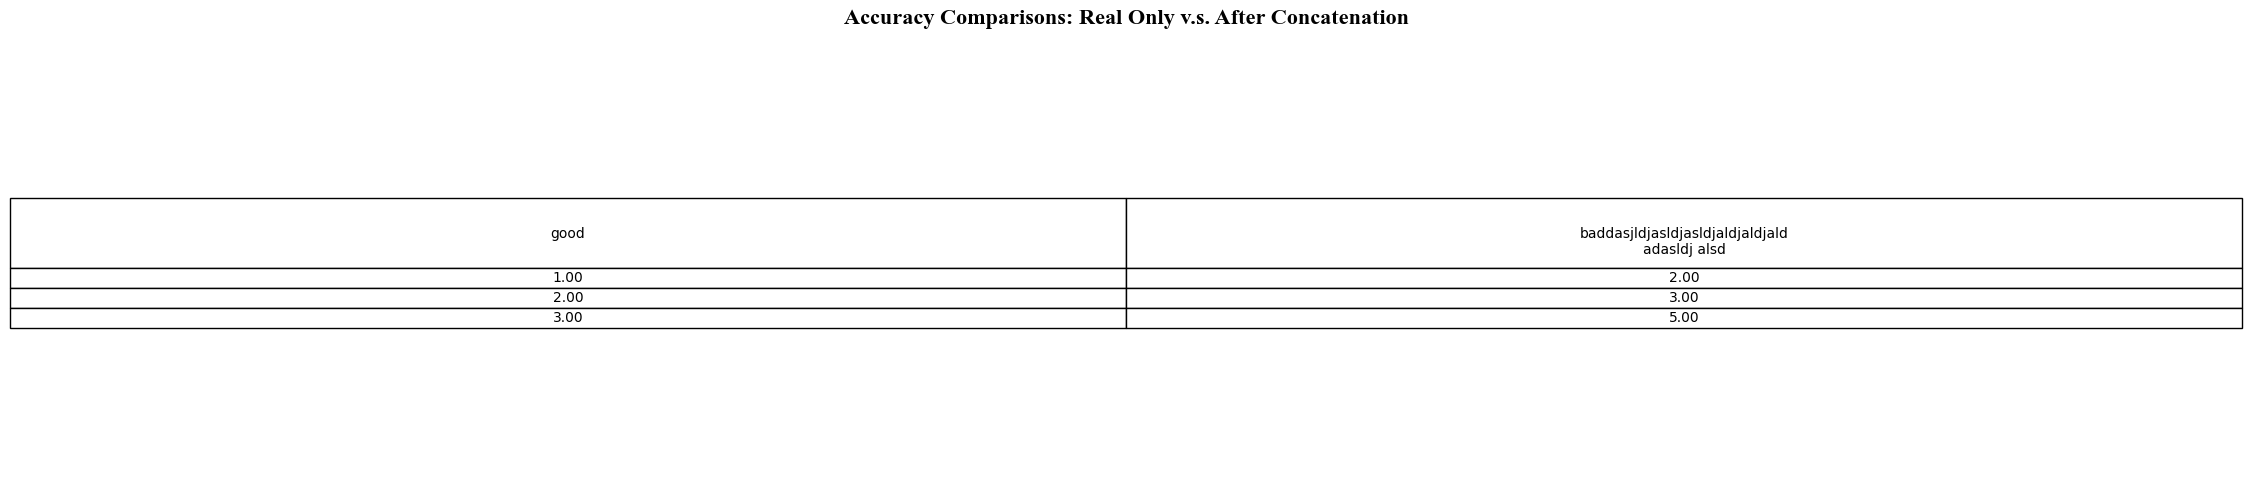

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import textwrap

def save_table_as_image(
        summary_df,
        file_name="accuracy_summary.png",
        title="Accuracy Comparisons: Real Only v.s. After Concatenation",
        decimal_places=2,
        max_col_width=20  # Maximum character width before wrapping
    ):
    """
    Save the entire DataFrame as an image with properly wrapped headers.
    - Wraps headers at spaces for better readability
    - Rounds numerical values to `decimal_places`
    - Adjusts row height dynamically based on header size
    """
    # Round numerical values to the specified decimal places
    summary_df = summary_df.copy()
    for col in summary_df.select_dtypes(include=[np.number]).columns:
        summary_df[col] = summary_df[col].apply(lambda x: f"{x:.{decimal_places}f}")

    # Convert DataFrame to a list of lists for table display
    summary_data = summary_df.values.tolist()

    # Wrap headers at spaces
    def wrap_header(header, width):
        # Split the header into words
        words = header.split(' ')
        
        # If the header is shorter than the max width, no wrapping is needed.
        if len(header) <= width:
            return header

        lines = []
        current_line = ""
        
        # Iterate through each word and build lines that do not exceed the max width.
        for word in words:
            # Check if adding the next word exceeds the width (account for a space if needed)
            if len(current_line) + len(word) + (1 if current_line else 0) > width:
                lines.append(current_line)
                current_line = word
            else:
                # Add a space before the word if current_line is not empty
                current_line = f"{current_line} {word}".strip()
        
        # Append the final line if it exists
        if current_line:
            lines.append(current_line)
        
        # Join the lines with newline characters for display
        return "\n".join(lines)

    wrapped_headers = [wrap_header(col, max_col_width) for col in summary_df.columns]

    # Determine the maximum number of wrapped lines in any header
    max_header_lines = max(len(header.split("\n")) for header in wrapped_headers)
    # Define a header height factor (in inches) based on the number of lines.
    # (Adjust the multiplier as needed based on your font size.)
    header_height = 0.05 * max_header_lines

    # Calculate figure dimensions based on data and header size
    num_rows, num_cols = summary_df.shape
    fig_width = max(10, num_cols * 1.5)
    # Add extra height for the header rows
    fig_height = max(6, num_rows * 0.5 + header_height + 0.5)

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis("tight")
    ax.axis("off")

    # Create the table
    table = ax.table(
        cellText=summary_data,
        colLabels=wrapped_headers,
        loc="center",
        cellLoc="center",
        colWidths=[max_col_width * 0.06 for _ in wrapped_headers]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Scale the table for readability

    # Adjust the height of header cells (row 0) to match the header text
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_height(header_height)

    # Set the table title
    ax.set_title(title, fontweight='bold', fontsize=16, family="Times New Roman")

    plt.tight_layout()
    plt.savefig(file_name, dpi=300, bbox_inches="tight")
    print(f"Table has been saved as '{file_name}'")


# Example usage
summary_df = pd.DataFrame({
    'good': [1, 2, 3],
    'baddasjldjasldjasldjaldjaldjald adasldj alsd': [2, 3, 5]
})
save_table_as_image(summary_df)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.001
batch_size = 512
latent_dim = 128          
condition_dim = 10        
gan_epochs = 150            
generation_size = 1000

full_dataset = load_from_disk('../../data/full_dataset_new', keep_in_memory=True)
split_datasets = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split_datasets['train']
test_dataset = split_datasets['test']


train_x_full = np.array(train_dataset['embedding'])
train_y_full = np.array(train_dataset['labels'])


In [ ]:

def train_and_evaluate_dnn(model, train_loader, test_loader, num_epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_y.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
        train_loss = running_loss / total
        train_acc = correct / total
        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}")
    # Evaluate
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    test_acc = accuracy_score(all_labels, all_preds)
    return test_acc, all_preds, all_labels


train_ds = EmbeddingDataset(train_dataset)
test_ds = EmbeddingDataset(test_dataset)


In [ ]:
sample_sizes = [20, 50, 70, 100, 300, 1000, len(train_ds)]
dnn_accuracy_before = {}
dnn_accuracy_after = {}

for size in sample_sizes:
    print(f"\n[Real Data Only] Training size: {size}")
    train_subset = torch.utils.data.Subset(train_ds, range(size))
    train_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = get_loader(test_ds, batch_size=batch_size, shuffle=False)

    input_dim = train_ds[0][0].shape[0]  
    hidden_dim = 128
    num_classes = len(np.unique(train_y_full)) if 'train_y_full' in globals() else 3
    dnn_model = DNNClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=0.5)
    dnn_model.to(device)
    
    print("Training DNN on real data...")
    acc_before, preds_before, labels_before = train_and_evaluate_dnn(dnn_model, train_loader, test_loader, num_epochs, learning_rate, device)
    print(f"DNN Test Accuracy (Real Data) for sample size {size}: {acc_before:.4f}")
    dnn_accuracy_before[size] = acc_before
    

    generator = Generator(
        latent_dim=latent_dim,
        condition_dim=condition_dim,
        num_classes=num_classes,
        start_dim=latent_dim * 2,
        n_layer=3,
        output_dim=input_dim  
    )
    discriminator = Discriminator(
        condition_dim=condition_dim,
        num_classes=num_classes,
        start_dim=256,
        n_layer=3,
        input_dim=input_dim
    )
    generator.to(device)
    discriminator.to(device)
    adversarial_loss = nn.BCELoss().to(device)


    optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    
    gan_loader = get_loader(train_subset, batch_size=batch_size, shuffle=True)
    for epoch in range(gan_epochs):
        d_loss_epoch, g_loss_epoch = 0.0, 0.0
        for embeddings, labels in gan_loader:
            embeddings = embeddings.to(device)
            labels = torch.tensor(labels, dtype=torch.long).to(device)
            b_size = embeddings.size(0)
            valid = torch.ones(b_size, 1, device=device)
            fake = torch.zeros(b_size, 1, device=device)
            # -----------------
            # Train Generator
            # -----------------
            optimizer_G.zero_grad()
            z = torch.randn(b_size, latent_dim, device=device)
            gen_data = generator(z, labels)
            g_loss = adversarial_loss(discriminator(gen_data, labels), valid)
            g_loss.backward()
            optimizer_G.step()
            # -----------------
            # Train Discriminator
            # -----------------
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(embeddings, labels), valid)
            fake_loss = adversarial_loss(discriminator(gen_data.detach(), labels), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()
        print(f"[GAN Epoch {epoch+1}/{gan_epochs}] D loss: {d_loss_epoch/len(gan_loader):.4f}, G loss: {g_loss_epoch/len(gan_loader):.4f}")
    

    synthetic_data_list = []
    synthetic_labels_list = []
    unique_labels = np.unique(train_y_full) if 'train_y_full' in globals() else [0,1,2]
    for lab in unique_labels:
        lab_tensor = torch.full((generation_size,), lab, dtype=torch.long, device=device)
        z = torch.randn(generation_size, latent_dim, device=device)
        synth = generator(z, lab_tensor).cpu().detach().numpy()
        synthetic_data_list.append(synth)
        synthetic_labels_list.append(np.full((generation_size,), lab))
    synthetic_x = np.concatenate(synthetic_data_list, axis=0)
    synthetic_y = np.concatenate(synthetic_labels_list, axis=0)
    
    # -------------------------------
    # Concatenate original training data with synthetic data
    # -------------------------------
    X_train = train_x_full[:size]
    y_train = train_y_full[:size]
    train_combined_x = np.concatenate([X_train, synthetic_x], axis=0)
    train_combined_y = np.concatenate([y_train, synthetic_y], axis=0)
    
    train_combined_dataset = TensorDataset(torch.tensor(train_combined_x, dtype=torch.float),
                                             torch.tensor(train_combined_y, dtype=torch.long))
    train_combined_loader = DataLoader(train_combined_dataset, batch_size=batch_size, shuffle=True)

    dnn_model_aug = DNNClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes, dropout=0.5)
    dnn_model_aug.to(device)
    
    print("Training DNN on real + synthetic (concatenated) data...")
    acc_after, preds_after, labels_after = train_and_evaluate_dnn(dnn_model_aug, train_combined_loader, test_loader, num_epochs, learning_rate, device)
    print(f"DNN Test Accuracy (After Concatenation) for sample size {size}: {acc_after:.4f}")
    dnn_accuracy_after[size] = acc_after

summary_df = pd.DataFrame(
    [[s, dnn_accuracy_before[s], dnn_accuracy_after[s]] for s in sample_sizes],
    columns=["Train Samples", "Real Only Accuracy", "After Concatenation Accuracy"]
)
print("Accuracy Summary:")
print(tabulate.tabulate(summary_df.values, headers=summary_df.columns, tablefmt="fancy_grid"))

plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, list(dnn_accuracy_before.values()), marker='o', linestyle='-', color='b', markersize=8, label="Real Only")
plt.plot(sample_sizes, list(dnn_accuracy_after.values()), marker='s', linestyle='--', color='r', markersize=8, label="After Concatenation")
plt.xlabel("Training Size", fontsize=14, fontfamily="Times New Roman")
plt.ylabel("Accuracy", fontsize=14, fontfamily="Times New Roman")
plt.title("DNN Accuracy vs. Training Size (Real vs. Augmented)", fontsize=16, fontfamily="Times New Roman")
plt.xscale("log")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


[GAN Epoch 41/150] D loss: 0.1477, G loss: 2.1020
[GAN Epoch 42/150] D loss: 0.1391, G loss: 1.8850
[GAN Epoch 43/150] D loss: 0.0816, G loss: 2.8082
[GAN Epoch 44/150] D loss: 0.0680, G loss: 2.4499
[GAN Epoch 45/150] D loss: 0.0551, G loss: 2.7956
[GAN Epoch 46/150] D loss: 0.0580, G loss: 2.8905
[GAN Epoch 47/150] D loss: 0.0685, G loss: 2.5661
[GAN Epoch 48/150] D loss: 0.0594, G loss: 3.0853
[GAN Epoch 49/150] D loss: 0.0703, G loss: 2.3857
[GAN Epoch 50/150] D loss: 0.0550, G loss: 3.7924
[GAN Epoch 51/150] D loss: 0.0938, G loss: 1.9997
[GAN Epoch 52/150] D loss: 0.0568, G loss: 4.4260
[GAN Epoch 53/150] D loss: 0.0543, G loss: 2.5765
[GAN Epoch 54/150] D loss: 0.0510, G loss: 2.7518
[GAN Epoch 55/150] D loss: 0.0572, G loss: 3.5200
[GAN Epoch 56/150] D loss: 0.0881, G loss: 2.1108
[GAN Epoch 57/150] D loss: 0.0802, G loss: 4.4590
[GAN Epoch 58/150] D loss: 0.0776, G loss: 2.1294
[GAN Epoch 59/150] D loss: 0.0198, G loss: 4.1835
[GAN Epoch 60/150] D loss: 0.0242, G loss: 4.2343


c:\Users\ss348\Desktop\New folder\GAN_Transformer\SICK\experiment\..\utility\data.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Epoch 3: Train Loss=0.2860, Train Acc=0.9160
Epoch 4: Train Loss=0.2773, Train Acc=0.9100
Epoch 5: Train Loss=0.2903, Train Acc=0.9090
Epoch 6: Train Loss=0.2923, Train Acc=0.9130
Epoch 7: Train Loss=0.2660, Train Acc=0.9180
Epoch 8: Train Loss=0.2753, Train Acc=0.9130
Epoch 9: Train Loss=0.2820, Train Acc=0.9160
Epoch 10: Train Loss=0.2606, Train Acc=0.9070
DNN Test Accuracy (Real Data) for sample size 1000: 0.9014
[GAN Epoch 1/150] D loss: 0.6723, G loss: 0.6869


c:\Users\ss348\Desktop\New folder\GAN_Transformer\SICK\experiment\..\utility\data.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
C:\Users\ss348\AppData\Local\Temp\ipykernel_48440\3598883103.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 2/150] D loss: 0.5616, G loss: 0.6870
[GAN Epoch 3/150] D loss: 0.4685, G loss: 0.6879
[GAN Epoch 4/150] D loss: 0.4051, G loss: 0.7021
[GAN Epoch 5/150] D loss: 0.3549, G loss: 0.7846
[GAN Epoch 6/150] D loss: 0.3191, G loss: 0.9211
[GAN Epoch 7/150] D loss: 0.3319, G loss: 0.9285
[GAN Epoch 8/150] D loss: 0.3742, G loss: 0.8647
[GAN Epoch 9/150] D loss: 0.3271, G loss: 0.9790
[GAN Epoch 10/150] D loss: 0.2271, G loss: 1.2438
[GAN Epoch 11/150] D loss: 0.1796, G loss: 1.4204
[GAN Epoch 12/150] D loss: 0.1694, G loss: 1.5442
[GAN Epoch 13/150] D loss: 0.1594, G loss: 1.6669
[GAN Epoch 14/150] D loss: 0.1331, G loss: 1.8747
[GAN Epoch 15/150] D loss: 0.1188, G loss: 2.1555
[GAN Epoch 16/150] D loss: 0.1729, G loss: 2.3473
[GAN Epoch 17/150] D loss: 0.2002, G loss: 1.8631
[GAN Epoch 18/150] D loss: 0.2408, G loss: 1.5982
[GAN Epoch 19/150] D loss: 0.6816, G loss: 1.8163
[GAN Epoch 20/150] D loss: 0.0571, G loss: 2.5067
[GAN Epoch 21/150] D loss: 0.1070, G loss: 1.9591
[GAN Epo

c:\Users\ss348\Desktop\New folder\GAN_Transformer\SICK\experiment\..\utility\data.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)


Training DNN on real data...
Epoch 1: Train Loss=0.4084, Train Acc=0.8473
Epoch 2: Train Loss=0.2704, Train Acc=0.9062
Epoch 3: Train Loss=0.2500, Train Acc=0.9116
Epoch 4: Train Loss=0.2423, Train Acc=0.9127
Epoch 5: Train Loss=0.2373, Train Acc=0.9129
Epoch 6: Train Loss=0.2294, Train Acc=0.9154
Epoch 7: Train Loss=0.2283, Train Acc=0.9145
Epoch 8: Train Loss=0.2278, Train Acc=0.9162
Epoch 9: Train Loss=0.2235, Train Acc=0.9172
Epoch 10: Train Loss=0.2223, Train Acc=0.9153
DNN Test Accuracy (Real Data) for sample size 7872: 0.9116


c:\Users\ss348\Desktop\New folder\GAN_Transformer\SICK\experiment\..\utility\data.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emb = torch.tensor(self.embeddings[idx], dtype=torch.float)
C:\Users\ss348\AppData\Local\Temp\ipykernel_48440\3598883103.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long).to(device)


[GAN Epoch 1/150] D loss: 0.4200, G loss: 0.8342
[GAN Epoch 2/150] D loss: 0.1769, G loss: 1.6197
[GAN Epoch 3/150] D loss: 0.1581, G loss: 2.4769
[GAN Epoch 4/150] D loss: 0.0878, G loss: 3.5341
[GAN Epoch 5/150] D loss: 0.3418, G loss: 2.9022
[GAN Epoch 6/150] D loss: 0.3856, G loss: 1.8816
[GAN Epoch 7/150] D loss: 0.2516, G loss: 2.3268
[GAN Epoch 8/150] D loss: 0.2923, G loss: 2.3845
[GAN Epoch 9/150] D loss: 0.2389, G loss: 2.5278
[GAN Epoch 10/150] D loss: 0.3095, G loss: 2.5461
[GAN Epoch 11/150] D loss: 0.2981, G loss: 2.2846
[GAN Epoch 12/150] D loss: 0.3247, G loss: 2.0774
[GAN Epoch 13/150] D loss: 0.3683, G loss: 2.3017
[GAN Epoch 14/150] D loss: 0.3967, G loss: 2.2365
[GAN Epoch 15/150] D loss: 0.3531, G loss: 1.9960
[GAN Epoch 16/150] D loss: 0.3740, G loss: 1.9943
[GAN Epoch 17/150] D loss: 0.4310, G loss: 2.0346
[GAN Epoch 18/150] D loss: 0.3838, G loss: 1.6115
[GAN Epoch 19/150] D loss: 0.4408, G loss: 1.9342
[GAN Epoch 20/150] D loss: 0.4376, G loss: 1.6715
[GAN Epoc